In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pickle
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
def rmse(y_pred, y_test):
    return mean_squared_error(y_pred, y_test, squared=False)

In [4]:
tf.random.set_seed(7)

In [5]:
df = pd.read_csv('google.csv')

In [6]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2004-08-19,51.835709,47.800831,49.813290,49.982655,44871361.0,49.982655
1,2004-08-20,54.336334,50.062355,50.316402,53.952770,22942874.0,53.952770
2,2004-08-23,56.528118,54.321388,55.168217,54.495735,18342897.0,54.495735
3,2004-08-24,55.591629,51.591621,55.412300,52.239197,15319808.0,52.239197
4,2004-08-25,53.798351,51.746044,52.284027,52.802086,9232276.0,52.802086
...,...,...,...,...,...,...,...
4312,2021-10-05,2747.239990,2680.000000,2680.000000,2723.540039,1206300.0,2723.540039
4313,2021-10-06,2757.040039,2689.729980,2692.510010,2747.080078,988200.0,2747.080078
4314,2021-10-07,2803.089111,2771.260010,2777.260010,2783.709961,912500.0,2783.709961
4315,2021-10-08,2806.340088,2788.586914,2798.120117,2801.120117,946200.0,2801.120117


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4317 entries, 0 to 4316
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4317 non-null   object 
 1   High       4317 non-null   float64
 2   Low        4317 non-null   float64
 3   Open       4317 non-null   float64
 4   Close      4317 non-null   float64
 5   Volume     4317 non-null   float64
 6   Adj Close  4317 non-null   float64
dtypes: float64(6), object(1)
memory usage: 236.2+ KB


In [8]:
df = df.set_index('Date')
df = df.sort_index()
df.index = pd.DatetimeIndex(df.index)
# df = df.reindex(index=pd.date_range(start='2004-08-19', end='2021-10-11'), method='nearest')

In [9]:
# df_ = df.copy()
# scaler = MinMaxScaler(feature_range=(0,1))
# for col in df.columns:
#     df_[col] = scaler.fit_transform(df[col].to_numpy().reshape(-1,1))

In [10]:
def create_train_and_test(data, look_back=1):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    training_len = int(len(data) * 0.8)
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data.reshape(-1,1)).flatten()
    
    train_data = data[:training_len]
    test_data = data[training_len-look_back:]
    
    for i in range(look_back, len(train_data)):
        x_train.append(train_data[i-look_back:i])
        y_train.append(train_data[i])
        
    for i in range(look_back, len(test_data)):
        x_test.append(test_data[i-look_back:i])
    
    y_test = data[training_len:]
        
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [11]:
high_trainX, high_trainy, high_testX, high_testy = create_train_and_test(df['High'].to_numpy(), look_back=60)
low_trainX, low_trainy, low_testX, low_testy = create_train_and_test(df['Low'].to_numpy(), look_back=60)
open_trainX, open_trainy, open_testX, open_testy = create_train_and_test(df['Open'].to_numpy(), look_back=60)
close_trainX, close_trainy, close_testX, close_testy = create_train_and_test(df['Close'].to_numpy(), look_back=60)
volume_trainX, volume_trainy, volume_testX, volume_testy = create_train_and_test(df['Volume'].to_numpy(), look_back=60)
adj_close_trainX, adj_close_trainy, adj_close_testX, adj_close_testy = create_train_and_test(df['Adj Close'].to_numpy(), look_back=60)

In [12]:
# Reshape the data
high_trainX = np.reshape(high_trainX, (high_trainX.shape[0], high_trainX.shape[1], 1))
low_trainX = np.reshape(low_trainX, (low_trainX.shape[0], low_trainX.shape[1], 1))
open_trainX = np.reshape(open_trainX, (open_trainX.shape[0], open_trainX.shape[1], 1))
close_trainX = np.reshape(close_trainX, (close_trainX.shape[0], close_trainX.shape[1], 1))
volume_trainX = np.reshape(volume_trainX, (volume_trainX.shape[0], volume_trainX.shape[1], 1))
adj_close_trainX = np.reshape(adj_close_trainX, (adj_close_trainX.shape[0], adj_close_trainX.shape[1], 1))

In [13]:
# Reshape the data
high_testX = np.reshape(high_testX, (high_testX.shape[0], high_testX.shape[1], 1))
low_testX = np.reshape(low_testX, (low_testX.shape[0], low_testX.shape[1], 1))
open_testX = np.reshape(open_testX, (open_testX.shape[0], open_testX.shape[1], 1))
close_testX = np.reshape(close_testX, (close_testX.shape[0], close_testX.shape[1], 1))
volume_testX = np.reshape(volume_testX, (volume_testX.shape[0], volume_testX.shape[1], 1))
adj_close_testX = np.reshape(adj_close_testX, (adj_close_testX.shape[0], adj_close_testX.shape[1], 1))

In [14]:
## Build the LSTM Model
look_back = 60
EPOCHS = 100

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(high_trainX, high_trainy, epochs=EPOCHS, batch_size=1, verbose=2)

Epoch 1/100
3393/3393 - 57s - loss: 1.5309e-04 - 57s/epoch - 17ms/step
Epoch 2/100
3393/3393 - 53s - loss: 5.7766e-05 - 53s/epoch - 16ms/step
Epoch 3/100
3393/3393 - 53s - loss: 4.3469e-05 - 53s/epoch - 16ms/step
Epoch 4/100
3393/3393 - 54s - loss: 3.6542e-05 - 54s/epoch - 16ms/step
Epoch 5/100
3393/3393 - 57s - loss: 2.9052e-05 - 57s/epoch - 17ms/step
Epoch 6/100
3393/3393 - 53s - loss: 2.5877e-05 - 53s/epoch - 16ms/step
Epoch 7/100
3393/3393 - 56s - loss: 2.8746e-05 - 56s/epoch - 16ms/step
Epoch 8/100
3393/3393 - 54s - loss: 2.1877e-05 - 54s/epoch - 16ms/step
Epoch 9/100
3393/3393 - 54s - loss: 2.3249e-05 - 54s/epoch - 16ms/step
Epoch 10/100
3393/3393 - 54s - loss: 2.2601e-05 - 54s/epoch - 16ms/step
Epoch 11/100
3393/3393 - 61s - loss: 2.3920e-05 - 61s/epoch - 18ms/step
Epoch 12/100
3393/3393 - 55s - loss: 1.9304e-05 - 55s/epoch - 16ms/step
Epoch 13/100
3393/3393 - 53s - loss: 1.8300e-05 - 53s/epoch - 16ms/step
Epoch 14/100
3393/3393 - 54s - loss: 1.7135e-05 - 54s/epoch - 16ms/step
E

In [26]:
model.save('model_1.h5')

In [16]:
with open('history_1.pkl', 'wb') as f:
    pickle.dump(history, f, protocol=pickle.HIGHEST_PROTOCOL)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-05-10 19:56:49         3059
metadata.json                                  2023-05-10 19:56:49           64
variables.h5                                   2023-05-10 1

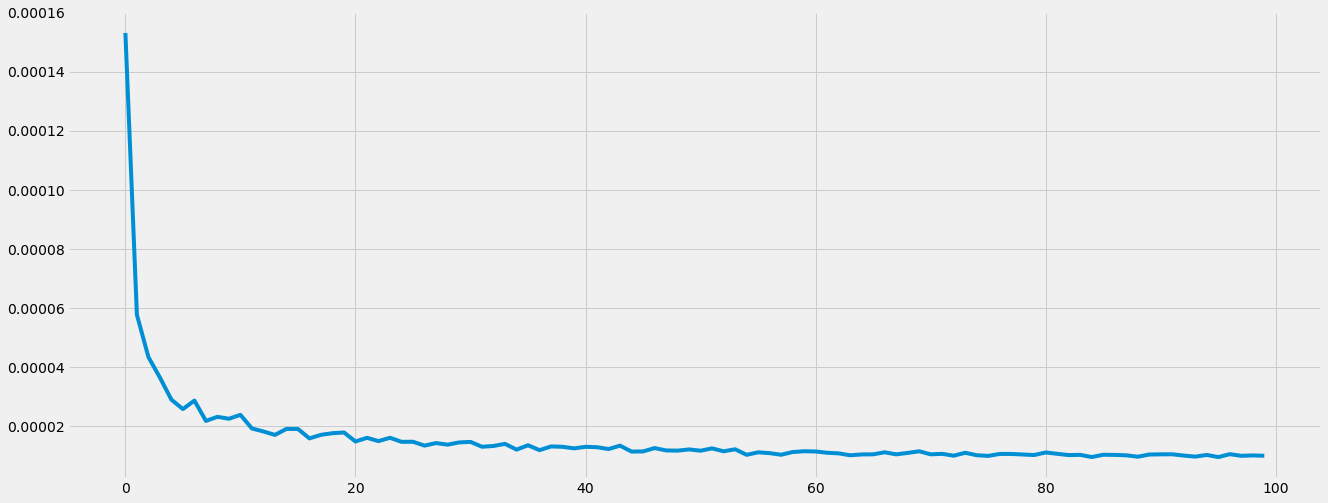

In [17]:
plt.figure(figsize=[20,8])
plt.plot(history.history['loss'])

In [18]:
print(np.argmin(history.history['loss']))

95


In [19]:
training_len = int(len(df) * 0.8)

yhigh_test = df['High'].to_numpy()[training_len:]

In [20]:
high_testX

array([[[0.34420752],
        [0.35028225],
        [0.3491976 ],
        ...,
        [0.33925386],
        [0.3457808 ],
        [0.35034465]],

       [[0.35028225],
        [0.3491976 ],
        [0.35382381],
        ...,
        [0.3457808 ],
        [0.35034465],
        [0.34995306]],

       [[0.3491976 ],
        [0.35382381],
        [0.36067096],
        ...,
        [0.35034465],
        [0.34995306],
        [0.35857823]],

       ...,

       [[0.90418715],
        [0.90140795],
        [0.89855253],
        ...,
        [0.92292767],
        [0.93444642],
        [0.93784246]],

       [[0.90140795],
        [0.89855253],
        [0.89206544],
        ...,
        [0.93444642],
        [0.93784246],
        [0.95379997]],

       [[0.89855253],
        [0.89206544],
        [0.89729364],
        ...,
        [0.93784246],
        [0.95379997],
        [0.95492654]]])

In [21]:
train_predict = model.predict(high_trainX)
test_predict = model.predict(high_testX)

scaler = MinMaxScaler()
test_predict = scaler.fit(df['High'].to_numpy().reshape(-1, 1)).inverse_transform(test_predict)

print(f"The Root Mean Square Error of the test data is: %.2f" % rmse(test_predict.flatten(), yhigh_test))

27/27 [==============================] - 0s 14ms/step
The Root Mean Square Error of the test data is: 135.20


In [27]:
test_predict

array([[1067.9575],
       [1066.2734],
       [1091.7991],
       [1105.342 ],
       [1105.3477],
       [1114.2346],
       [1091.2411],
       [1090.8027],
       [1087.3599],
       [1070.1483],
       [1090.417 ],
       [1088.7408],
       [1084.4478],
       [1085.0538],
       [1087.5454],
       [1078.0403],
       [1074.0792],
       [1102.7502],
       [1124.7681],
       [1146.8181],
       [1150.0166],
       [1146.523 ],
       [1137.8533],
       [1127.284 ],
       [1137.4492],
       [1139.328 ],
       [1146.9232],
       [1156.6185],
       [1155.2621],
       [1177.094 ],
       [1173.7058],
       [1189.2518],
       [1179.2274],
       [1164.1338],
       [1144.4987],
       [1133.4104],
       [1132.1825],
       [1123.194 ],
       [1130.8623],
       [1131.47  ],
       [1140.6771],
       [1132.4648],
       [1146.5875],
       [1159.415 ],
       [1163.7296],
       [1167.6882],
       [1186.759 ],
       [1196.4368],
       [1191.3801],
       [1202.7579],


In [28]:
test_pred_ser = pd.Series(test_predict.flatten(), index=df['High'][training_len:].index)

<AxesSubplot:xlabel='Date'>

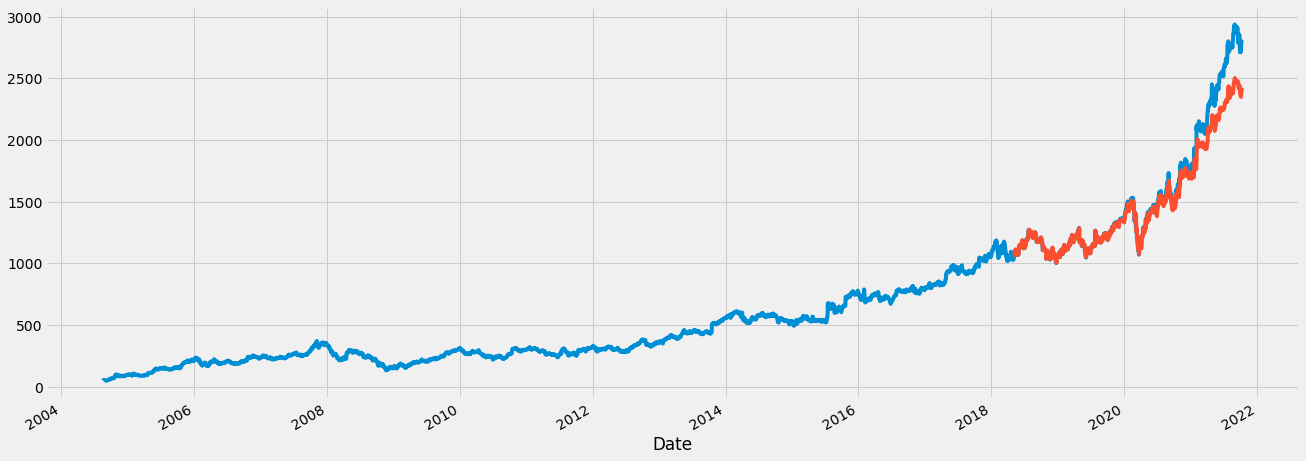

In [29]:
ax = df['High'].plot(figsize=(20,8))
test_pred_ser.plot()

<AxesSubplot:xlabel='Date'>

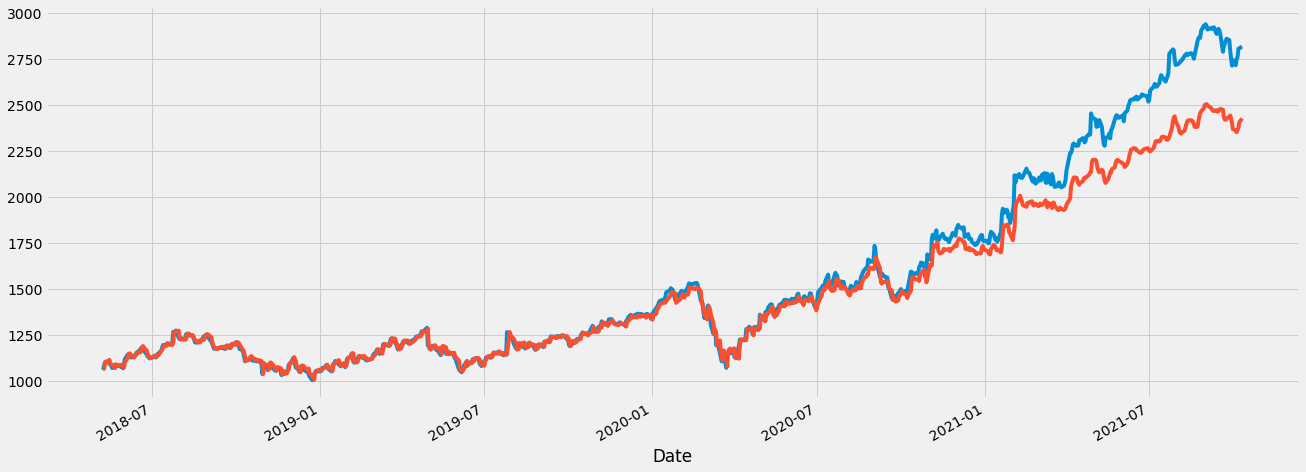

In [30]:
ax = df['High'][training_len:].plot(figsize=(20,8))
test_pred_ser.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

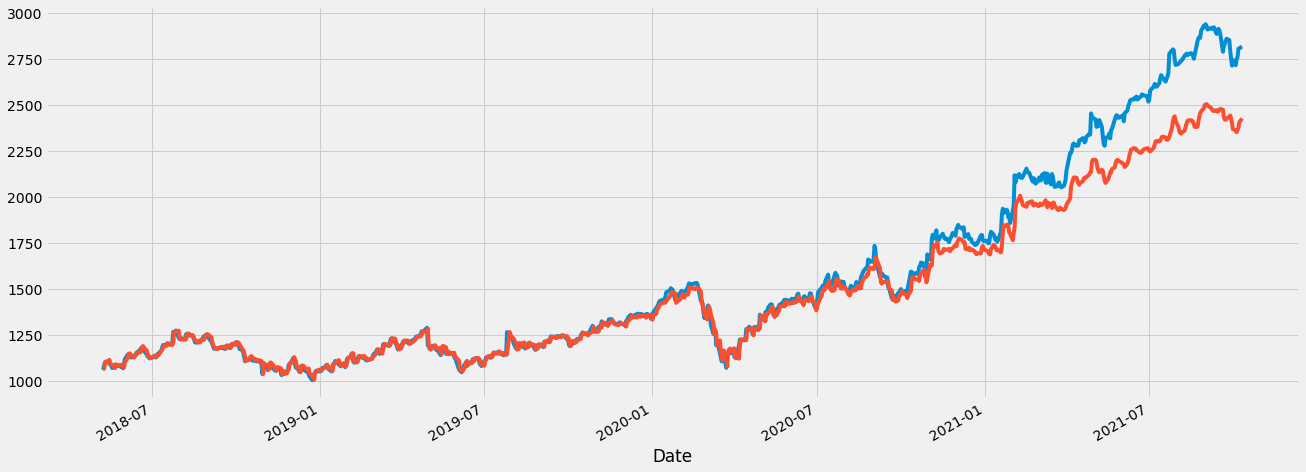

In [31]:
ax = df['High'][training_len:].plot(figsize=(20,8))
test_pred_ser.plot(ax=ax)

In [32]:
# predicting future values of the stock price

def predict_future_price(num_days=1, col='High'):
    pred_norm_values = []
    df_ = df.copy()
    scaler = MinMaxScaler()
    df_[col] = scaler.fit_transform(df[col].to_numpy().reshape(-1,1))
    training_len = int(0.8 * len(df))
    test_data = df_[col].to_numpy()[training_len:]
    
    pred_features = []
    pred_values = []
    for i in tqdm(range(num_days)):

        pred_features = test_data[-60:]
        pred_features = np.array(pred_features.reshape(1, 60, 1))
        pred_value = model.predict(pred_features, verbose=0)
        pred_values.append(pred_value.flatten()[0])
        test_data = list(test_data)
        test_data.append(pred_value.flatten()[0])
        test_data = np.array(test_data)
        
        
    pred_values = scaler.inverse_transform(np.array(pred_values).flatten().reshape(-1, 1)).ravel()
    return pred_values

In [33]:
predict_future_price()

  0%|          | 0/1 [00:00<?, ?it/s]

array([2439.219], dtype=float32)

In [34]:
predict_future_price(num_days=200)

  0%|          | 0/200 [00:00<?, ?it/s]

array([2439.219 , 2271.8967, 2090.4912, 1893.0282, 1704.2041, 1547.8298,
       1439.258 , 1382.677 , 1378.5455, 1419.2742, 1487.0453, 1563.0912,
       1633.2976, 1687.4124, 1717.4067, 1717.4541, 1685.337 , 1624.1405,
       1542.9252, 1455.3823, 1376.4001, 1317.8789, 1285.8369, 1279.8265,
       1294.4436, 1321.9775, 1354.7217, 1386.125 , 1411.1003, 1426.0896,
       1429.1964, 1420.3563, 1401.3639, 1375.5752, 1347.2426, 1320.6317,
       1299.1692, 1284.8726, 1278.191 , 1278.2249, 1283.1722, 1290.8322,
       1299.0289, 1305.9186, 1310.1832, 1311.1239, 1308.668 , 1303.2856,
       1295.845 , 1287.4254, 1279.117 , 1271.8414, 1266.2229, 1262.5267,
       1260.6755, 1260.3219, 1260.9558, 1262.0167, 1262.9907, 1263.4789,
       1263.2351, 1262.1748, 1260.3647, 1257.986 , 1255.2863, 1252.5303,
       1249.9553, 1247.7378, 1245.9746, 1244.683 , 1243.81  , 1243.2539,
       1242.888 , 1242.5847, 1242.2355, 1241.7633, 1241.1294, 1240.3322,
       1239.3997, 1238.3815, 1237.3358, 1236.32  , 